# Calibrating the Zahn Cup (Step 1)

The Zahn cup that we'll use in our viscosity lab was, unfortunately, very poorly calibrated by the manufacturer.  (A good rule of thumb with inexpensive lab equipment: "trust but verify"!)   The good news: this gives us a chance to calibrate an instrument that badly needs to be calibrated!

<br>

<center>
<img src = https://github.com/MAugspurger/Exper_Eng/raw/main/Labs_and_Sensors/Images/wholesome.PNG width = 300>
</center>

<br>

In this case, calibration is a little bit more complicated than simply hanging known masses from a load cell.  One reason is that our viscosity reference standard has a known viscosity, but that viscosity changes with temperature.   

<br>

Because of this, we need to be able to determine the viscosity of the reference standard at any temperature. So our first step in the calibration process is to find a *function* that describes the viscosity of the reference standard, of the form $\nu =f(T)$, where $T$ is the temperature.  That's what we'll do in this notebook!




## The Arrhenius function

Just as there are a range of reference standards for the masses we use to calibrate a load cell (50 g, 500 g, 5 kg, etc...), there are a range of viscosity reference standards.  Our viscosity reference standard is "N35", which we are using because it has viscosities that are similar to those of vegetable oils.  

<br>

<center>
<img src = https://github.com/MAugspurger/Exper_Eng/raw/main/Labs_and_Sensors/Images/N35_image.JPG width = 250>
</center>

<br>

The manufacturer of the N35 reference standard has published [a data sheet](https://drive.google.com/open?id=1c_SWbjQS5xEn9r9IPs-9hQwcGkPqHZN0&usp=drive_fs) that lists the viscosity of the standard at a set of defined temperatures.   If you look at that data sheet, you'll notice that the temperatures are defined to 4 significant digits ($25.00^o C$, for example), and the kinematic viscosity changes significantly with temperature.  In our lab, however we don't have the capacity to control the temperature of our fluid nearly to this high degree of accuracy.  Instead, we'll fit a curve to this known data, which will allow us to estimate fairly accurately the viscosity of the N35 standard at any temperature.

<br>

<center>
<img src = https://github.com/MAugspurger/Exper_Eng/raw/main/Labs_and_Sensors/Images/viscosity_reference_data.png width = 400>
</center>

<br>

Viscosity, though, is tricky: as a function of temperature, viscosity does not fit a "standard" (linear, exponential, or polynomial) curve.  Instead, the functional relationship between viscosity and temperature is most often expressed as an *Arrhenius equation*.  This equation has the form:

<br>

$$\nu = \nu_0 e^{B/T} $$

<br>

where B is a constant related to intermolecular energies that control viscosity and $\nu_0$ is a constant that defines a lower limit to the viscosity as the temperature $T$ gets very high. The temperature $T$ must be in Kelvin.

<br>



## Coding an Arrhenius function

MAIN POINT: We have a small number of known points for our reference standard, but want to fit an Arrhenius curve to these points so that we'll have function that describes the viscosity of the reference standard at any temperature.

<br>

In order to fit an Arrhenius curve to our data, we'll need to find the values of $B$ and $\nu_0$ that make the curve get as close to our known data points as possible.

<br>

In order to do that, we'll first need to create a function that will make an Arrhenius curve.  The function should pull in the coefficients `nu_0` and `B` as arguments; the third argument,  `T_array`, will be an array of temperature values in our range of interest ($10-50^o C$).   

<br>

<center>
<img src = https://github.com/MAugspurger/Exper_Eng/raw/main/Labs_and_Sensors/Images/nu_knot.PNG width = 400>
</center>

<br>

✅ ✅ Active Learning: The function below is still unfinished.  Before moving on, choose the appropriate forms of the equation and of the return line:


In [9]:
import pandas as pd
import numpy as np

def arrhenius(nu_0,B,T_array):
    # Choose the best way to calculate the viscosity value (remove the other three)
    nu = nu_0 * np.exp(B/(T_array*273.15))
    nu = nu_0 * np.exp(B/(T_array))
    nu = nu_0 * np.exp(B*T_array)
    nu = nu_0 * np.exp(B/(T_array+273.15))

    # Choose the appropriate return line (remove the other three)
    return pd.Series(index = T_array,data=nu)
    return pd.Series(index = nu, data=T_array)
    return pd.Series(index = nu,data=nu_0)
    return pd.Series(index = nu_0,data=nu)

And run this cell to test the function and see an example of an Arrhenius curve.  You should see a curve that starts at about $450 ~cSt$, drops quickly as the temperature rises, and then begins to flatten out a bit near the top of the temperature range.

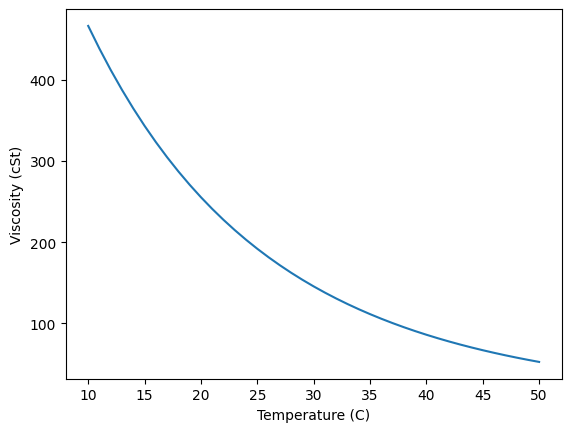

In [10]:
# Define the temperature range
T_array = np.linspace(10,50,41)

# Define the viscosity values
example_curve = arrhenius(1.0e-5,5000,T_array)

# Plot the example curve
example_curve.plot(xlabel='Temperature (C)', ylabel='Viscosity (cSt)');

## Importing the known data

MAIN POINT: Now that we can plot an Arrhenius curve, we want to adapt the coefficients in order to fit the curve to the known data points for the N35 reference standard.  

<br>

First, we need those known data points.  The cell below pulls the data for our temperature range into the Colab environment.

In [11]:
# Import Pandas and give it the shorthand name "pd"
import pandas as pd

# Define the file we want to import
address = 'https://github.com/MAugspurger/Exper_Eng/raw/main/'
file_loc = 'Labs_and_Sensors/Arrhenius_Curve/Standard_N35_values.xlsx'

# Import the world population data
N35_data = pd.read_excel(address + file_loc, header=0,index_col=0)
N35_data

,Kinematic viscosity (cSt)
Temperature (°C),
20.00,86.54
25.00,65.66
37.78,35.47
40.00,32.19
50.00,21.64


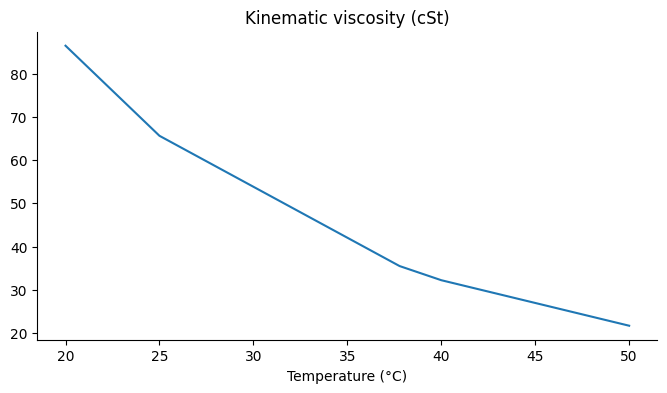

In [4]:
# @title Kinematic viscosity (cSt)

from matplotlib import pyplot as plt
N35_data['Kinematic viscosity (cSt)'].plot(kind='line', figsize=(8, 4), title='Kinematic viscosity (cSt)')
plt.gca().spines[['top', 'right']].set_visible(False)

Click "View recommended plots" and confirm that the data has the same rough shape as the Arrhenius plot we created in the previous step.

### Using a Least Squares algorithm to fit the curve

The shape of our curve is determined by the values of $B$ and $\nu_0$.  We want to find the values for these parameters that fits the data.   The class notes included an expression for the *deviation* $D$ that is minimized in a least squares process:

<br>

$$D= \sum_{i=1}^{N} (y_i - y_{curve,i})^2$$

<br>

where $y_i$ is the $y$ value of the $N$ known data points, and $y_{curve,i}$ is the $y$ value of the curve at the same $x$ values.  In the notes, we discussed this in relation to linear curve fitting, but this definition of deviation can be used with any type of curve.  And that's what we'll find here: the best curve is the one where the sum $D$ is minimized.

<br>

Python, fortunately, can save us a lot of trouble: all we need to do is define $y_i - y_{curve,i}$ in an `deviation_func()` function, and a SciPy library function will minimize the return of that function.  Here's that deviation function.  `params` will hold values for the coefficients $B$ and $\nu_0$; `known_data` contains the temperature and viscosity values from the N35 reference standard:

In [12]:
def deviation_func(params, known_data):
    # Calculate the viscosities at known temperature values
    arrh = arrhenius(params[0],params[1],known_data.index)
    # Find difference between calculated viscosities and known reference viscosities
    errors = arrh - known_data.values[:,0]
    return errors


Notice that we put in `data.index` as our `T_array` in line 3: this is because we need `arrh` and `data` defined at the same temperatures so that we can find the difference between them in line 5.  

<br> We can run this with some estimated parameters:

,Temperature (°C)
Temperature (°C),
20.00,5.846920
25.00,6.870123
37.78,5.012132
40.00,4.570210
50.00,2.561359


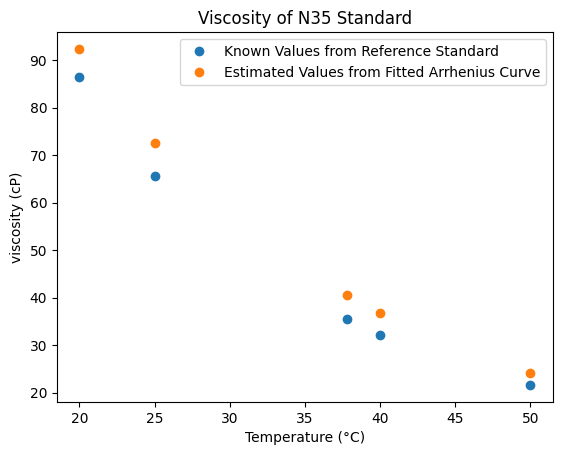

In [13]:
params = [0.00005,4230]
arrh = arrhenius(params[0],params[1],N35_data.index)
N35_data['Kinematic viscosity (cSt)'].plot(ylabel = 'viscosity (cP)', xlabel = 'Temperature (C)',
           title = 'Viscosity of N35 Standard', style = 'o',legend=True,
            label='Known Values from Reference Standard');
arrh.plot(style='o', label='Estimated Values from Fitted Arrhenius Curve', legend=True)
deviation_func(params,N35_data)

Look at this plot and convince yourself that the list of errors matches with the plot.

<br>

Remember that the Arrhenius curve points above are the result of an educated guess on our part.  But get our curve points as close as possible to the reference standard points.  To do that, we will use the function `leastsq()`.  This function, which is part of the SciPy library, will alter the coefficients in `params` in order to minimize the deviation that we defined in our function above:

In [14]:
import scipy.optimize as spo
best_params, fit_details = spo.leastsq(deviation_func, params, N35_data)

The two values in `best_params` that the function produces are the optimized values of $B$ and $\nu_0$.   Now we can plot the fitted curve with the known data and see how well an Arrhenius function can fit the known data:

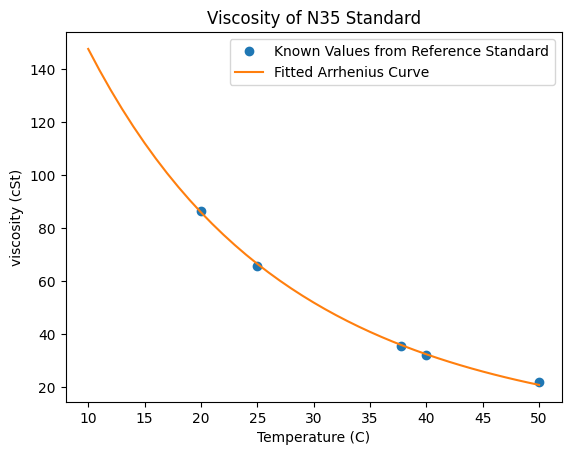

In [15]:
temp_range = np.linspace(10.0,50.0,41)
arrh_best = arrhenius(best_params[0],best_params[1],temp_range)
N35_data['Kinematic viscosity (cSt)'].plot(ylabel = 'viscosity (cSt)',
        xlabel = 'Temperature (C)', title = 'Viscosity of N35 Standard',
            style = 'o',legend=True, label='Known Values from Reference Standard');
arrh_best.plot(label='Fitted Arrhenius Curve', legend =True);

Looks pretty good!  Our fitted Arrhenius curve matches the known data for the reference standard very nicely.  

<br>

MAIN POINT: Now we have a function that describes the viscosity of the reference standard at any given temperature!

### Active Learning

✅ ✅ Create a code cell below this one, and use it to print out the optimized values for the two Arrhenius coefficients, $B$ and $\nu_0$.

✅ ✅ Identify the values of the two coefficients in this text cell.